In [17]:
import numpy as np
import pandas as pd
from scipy import io
from os import listdir
import os
import urllib.request
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

import time
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline


from tqdm import tqdm

### helper functions
from dataset_loader import SPD_dataset
from spdnet_init_afew import spdnet_init_afew
from spdnet.utils.load_data import load_data
from accumulate_gradients import accumulate_gradients
from spdnet.vl_folder.vl_myforbackward import vl_myforbackward
from nilearn.connectome import ConnectivityMeasure

## Load ADISE dataset

In [2]:
dir_abide = '/Users/annakuzina/Google Drive/study/masters/research/working stuff/depression/data/abide/Outputs/cpac/filt_global/rois_aal'

In [3]:
# Get correlation matrices
files = listdir(dir_abide)
subjects = []
correlation_measure = ConnectivityMeasure(kind='correlation')
X = []
for f in files:
    matr = pd.read_csv(dir_abide + '/' + f, '\t')
    correlation_matrix = correlation_measure.fit_transform([np.asarray(matr)])[0]
    np.fill_diagonal(correlation_matrix, 0)
    X.append(correlation_matrix)
    subjects.append(f.split('_')[-3][2:])
X = np.stack(X)

In [4]:
# Get all labels
s3_prefix = 'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative'
s3_pheno_path = '/'.join([s3_prefix, 'Phenotypic_V1_0b_preprocessed1.csv'])

derivative = 'rois_aal'
pipeline = 'cpac'
strategy = 'filt_global'

s3_pheno_file = urllib.request.urlopen(s3_pheno_path)
pheno_list = s3_pheno_file.readlines()
header = str(pheno_list[0]).split(',')

label_idx = header.index('DX_GROUP')
subject_idx = header.index('SUB_ID')

all_labels = []
sub_id = []
for i in range(1,len(pheno_list)):
    all_labels.append(int(str(pheno_list[i]).split(',')[label_idx]))
    sub_id.append(str(pheno_list[i]).split(',')[subject_idx])
sub_id = np.array(sub_id)
all_labels = np.array(all_labels)

In [5]:
# Get y 
y = []
for sub in subjects:
    y.append(all_labels[np.where(sub_id == sub)[0][0]])

# Additional functions

In [6]:
def iterate_minibathces(X, y, batchsize):
    """
    X = 3-dim tensor (data_size, rows=116, cols=116)
    """
    indices = np.random.permutation(np.arange(X.shape[0]))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [26]:
def calculate_error(true_labels, predictions, print_result = False):
    
    ind = np.argsort(-predictions, axis = 1)[:, 0]
    answer = np.sum(ind != true_labels-1)
    
    if print_result:
        print("true_labels", true_labels)
        u, indices = np.unique(true_labels, return_counts=True)
        print("Must_have", u[np.argmax(indices)])
        print("ind", ind)
    
    return answer / predictions.shape[0]

# Training

In [24]:
opts = {}

opts['batchSize'] = 40
opts['test_batchSize'] = 1
opts['numEpochs'] = 200
opts['learningRate'] = 0.01 * np.ones(opts['numEpochs'])
opts['learningRate'][100:] = 0.005
opts['weightDecay'] = 0.05
opts['continue'] = 1

In [9]:
y_enc = np.array(y)
# y_enc[np.array(y) == 1] = 1
# y_enc[np.array(y) == 2] = 0
X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size = 0.2, stratify = y_enc)

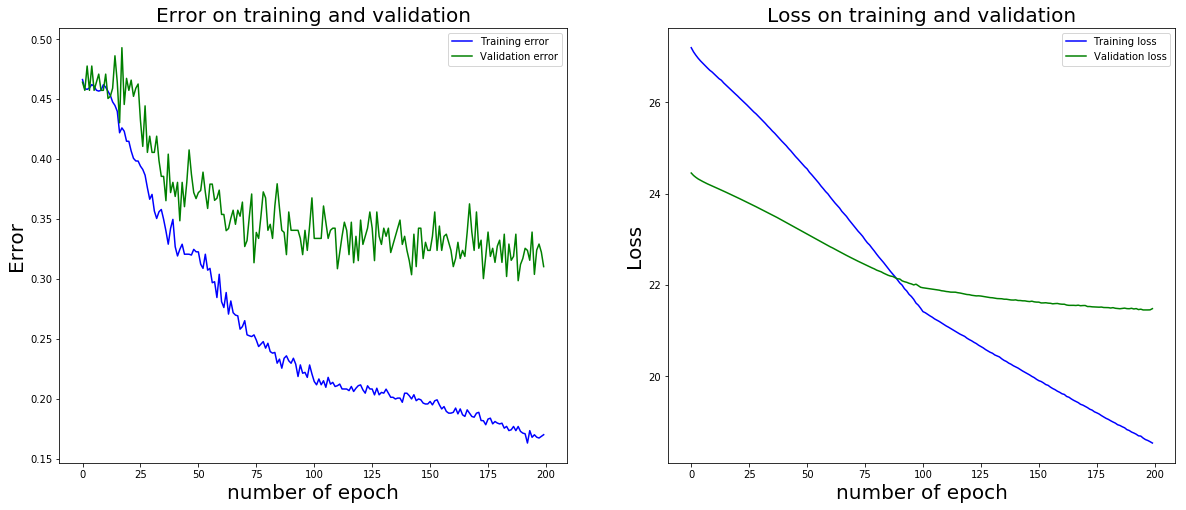

Epoch 200 of 200 took 7.203s
  training error: 	0.170062
  validation error: 	0.310294 
  training loss: 	18.537155
  validation loss: 	21.480317 


In [10]:
num_epochs = opts['numEpochs']

net = spdnet_init_afew(12336)

train_error = []
val_error = []

train_loss = []
val_loss = []


for epoch in range(opts['numEpochs']):

    start_time = time.time()

    train_error_per_epoch = []
    val_error_per_epoch = []

    train_loss_per_epoch = []
    val_loss_per_epoch = []

    zz = 0

    # training mode
    net['train_mode'] = True

    for X_batch, y_batch in iterate_minibathces(X_train, y_train, opts['batchSize']):
        print('batch num: ', zz + 1)

        net['layers'][-1]['class'] = y_batch
        res = vl_myforbackward(net=net, x=X_batch, dzdy=1, res=None, varargin=None)
        [net, res] = accumulate_gradients(opts=None, lr=opts['learningRate'][epoch], 
                                          batchSize=X_batch.shape[0], net=net, res=res)
        predictions = res['x'][-2]

        train_error_per_epoch.append(calculate_error(y_batch, predictions))
        train_loss_per_epoch.append(res['x'][-1])

        zz += 1


    train_error.append(np.mean(train_error_per_epoch))
    train_loss.append(np.mean(train_loss_per_epoch))


    # test mode
    net['train_mode'] = False

    for X_batch, y_batch in iterate_minibathces(X_val, y_val, opts['batchSize']):
        net['layers'][-1]['class'] = y_batch
        res = vl_myforbackward(net=net, x=X_batch, dzdy=None, res=None)

        predictions = res['x'][-2]

        val_error_per_epoch.append(calculate_error(y_batch, predictions))
        val_loss_per_epoch.append(res['x'][-1])


    val_error.append(np.mean(val_error_per_epoch))
    val_loss.append(np.mean(val_loss_per_epoch))

    # Visualize and print the results

    display.clear_output(wait=True)

    # Visualize

    fig = plt.figure(figsize=(20, 8))
    plot1 = fig.add_subplot(121)
    plot2 = fig.add_subplot(122)


    plot1.set_title("Error on training and validation", size = 20)
    plot1.set_xlabel("number of epoch", size = 20)
    plot1.set_ylabel("Error", size = 20)
    plot1.plot(train_error, 'b', label="Training error")
    plot1.plot(val_error, 'g', label="Validation error")

    plot1.legend()


    plot2.set_title("Loss on training and validation", size = 20)
    plot2.set_xlabel("number of epoch", size = 20)
    plot2.set_ylabel("Loss", size = 20)
    plot2.plot(train_loss, 'b', label="Training loss")
    plot2.plot(val_loss, 'g', label="Validation loss")

    plot2.legend()

    plt.show()

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training error: \t{:.6f}".format(
        np.mean(train_error[-1])))
    print("  validation error: \t{:.6f} ".format(
        np.mean(val_error[-1])))

    print("  training loss: \t{:.6f}".format(
        np.mean(train_loss[-1])))
    print("  validation loss: \t{:.6f} ".format(
        np.mean(val_loss[-1])))



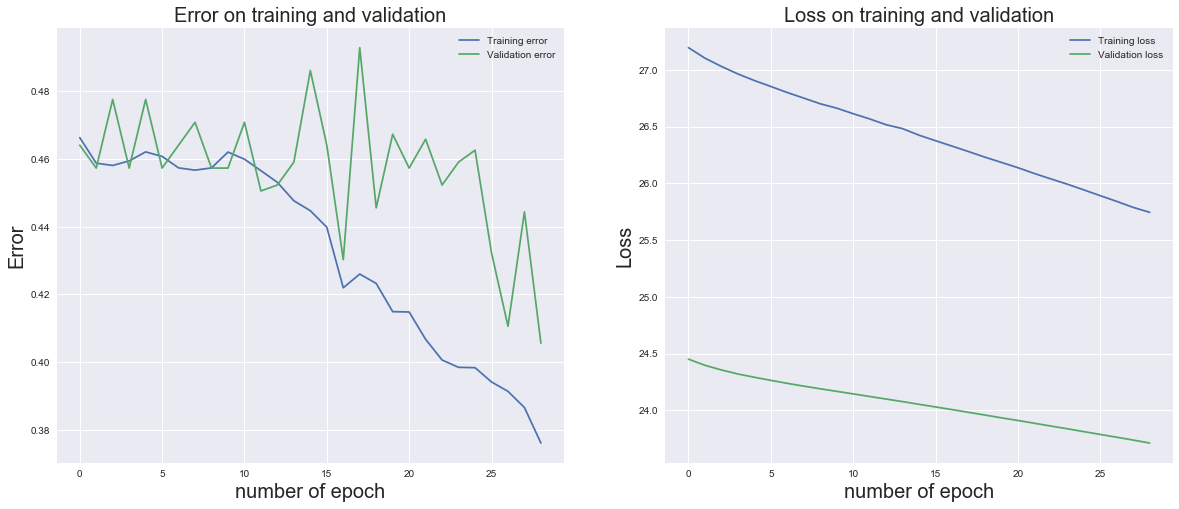

Epoch 29 of 200 took 7.703s
  training error: 	0.376080
  validation error: 	0.405588 
  training loss: 	25.744494
  validation loss: 	23.711643 
batch num:  1
batch num:  2
batch num:  3


KeyboardInterrupt: 

In [29]:
num_epochs = opts['numEpochs']

net = spdnet_init_afew(12336)

train_error = []
val_error = []

train_loss = []
val_loss = []


for epoch in range(opts['numEpochs']):

    start_time = time.time()

    train_error_per_epoch = []
    val_error_per_epoch = []

    train_loss_per_epoch = []
    val_loss_per_epoch = []

    zz = 0

    # training mode
    net['train_mode'] = True

    for X_batch, y_batch in iterate_minibathces(X_train, y_train, opts['batchSize']):
        print('batch num: ', zz + 1)

        net['layers'][-1]['class'] = y_batch
        res = vl_myforbackward(net=net, x=X_batch, dzdy=1, res=None, varargin=None)
        [net, res] = accumulate_gradients(opts=None, lr=opts['learningRate'][epoch], 
                                          batchSize=X_batch.shape[0], net=net, res=res)
        predictions = res['x'][-2]

        train_error_per_epoch.append(calculate_error(y_batch, predictions))
        train_loss_per_epoch.append(res['x'][-1])

        zz += 1


    train_error.append(np.mean(train_error_per_epoch))
    train_loss.append(np.mean(train_loss_per_epoch))


    # test mode
    net['train_mode'] = False

    for X_batch, y_batch in iterate_minibathces(X_val, y_val, opts['batchSize']):
        net['layers'][-1]['class'] = y_batch
        res = vl_myforbackward(net=net, x=X_batch, dzdy=None, res=None)

        predictions = res['x'][-2]

        val_error_per_epoch.append(calculate_error(y_batch, predictions))
        val_loss_per_epoch.append(res['x'][-1])


    val_error.append(np.mean(val_error_per_epoch))
    val_loss.append(np.mean(val_loss_per_epoch))

    # Visualize and print the results

    display.clear_output(wait=True)

    # Visualize

    fig = plt.figure(figsize=(20, 8))
    plot1 = fig.add_subplot(121)
    plot2 = fig.add_subplot(122)


    plot1.set_title("Error on training and validation", size = 20)
    plot1.set_xlabel("number of epoch", size = 20)
    plot1.set_ylabel("Error", size = 20)
    plot1.plot(train_error, 'b', label="Training error")
    plot1.plot(val_error, 'g', label="Validation error")

    plot1.legend()


    plot2.set_title("Loss on training and validation", size = 20)
    plot2.set_xlabel("number of epoch", size = 20)
    plot2.set_ylabel("Loss", size = 20)
    plot2.plot(train_loss, 'b', label="Training loss")
    plot2.plot(val_loss, 'g', label="Validation loss")

    plot2.legend()

    plt.show()

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training error: \t{:.6f}".format(
        np.mean(train_error[-1])))
    print("  validation error: \t{:.6f} ".format(
        np.mean(val_error[-1])))

    print("  training loss: \t{:.6f}".format(
        np.mean(train_loss[-1])))
    print("  validation loss: \t{:.6f} ".format(
        np.mean(val_loss[-1])))




In [30]:
def train(X_train, y_train, X_val, y_val):
    num_epochs = opts['numEpochs']
    net = spdnet_init_afew(12336)

    train_error = []
    val_error = []

    train_loss = []
    val_loss = []


    for epoch in range(opts['numEpochs']):

        start_time = time.time()

        train_error_per_epoch = []
        val_error_per_epoch = []

        train_loss_per_epoch = []
        val_loss_per_epoch = []

        zz = 0

        # training mode
        net['train_mode'] = True

        for X_batch, y_batch in iterate_minibathces(X_train, y_train, opts['batchSize']):
            print('batch num: ', zz + 1)

            net['layers'][-1]['class'] = y_batch
            res = vl_myforbackward(net=net, x=X_batch, dzdy=1, res=None, varargin=None)
            [net, res] = accumulate_gradients(opts=None, lr=opts['learningRate'][epoch], 
                                              batchSize=X_batch.shape[0], net=net, res=res)
            predictions = res['x'][-2]

            train_error_per_epoch.append(calculate_error(y_batch, predictions))
            train_loss_per_epoch.append(res['x'][-1])

            zz += 1


        train_error.append(np.mean(train_error_per_epoch))
        train_loss.append(np.mean(train_loss_per_epoch))


        # test mode
        net['train_mode'] = False

        for X_batch, y_batch in iterate_minibathces(X_val, y_val, opts['batchSize']):
            net['layers'][-1]['class'] = y_batch
            res = vl_myforbackward(net=net, x=X_batch, dzdy=None, res=None)

            predictions = res['x'][-2]

            val_error_per_epoch.append(calculate_error(y_batch, predictions))
            val_loss_per_epoch.append(res['x'][-1])


        val_error.append(np.mean(val_error_per_epoch))
        val_loss.append(np.mean(val_loss_per_epoch))

        # Visualize and print the results

        display.clear_output(wait=True)

        # Visualize

        fig = plt.figure(figsize=(20, 8))
        plot1 = fig.add_subplot(121)
        plot2 = fig.add_subplot(122)


        plot1.set_title("Error on training and validation", size = 20)
        plot1.set_xlabel("number of epoch", size = 20)
        plot1.set_ylabel("Error", size = 20)
        plot1.plot(train_error, 'b', label="Training error")
        plot1.plot(val_error, 'g', label="Validation error")

        plot1.legend()


        plot2.set_title("Loss on training and validation", size = 20)
        plot2.set_xlabel("number of epoch", size = 20)
        plot2.set_ylabel("Loss", size = 20)
        plot2.plot(train_loss, 'b', label="Training loss")
        plot2.plot(val_loss, 'g', label="Validation loss")

        plot2.legend()

        plt.show()

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training error: \t{:.6f}".format(
            np.mean(train_error[-1])))
        print("  validation error: \t{:.6f} ".format(
            np.mean(val_error[-1])))

        print("  training loss: \t{:.6f}".format(
            np.mean(train_loss[-1])))
        print("  validation loss: \t{:.6f} ".format(
            np.mean(val_loss[-1])))
    del net
    return train_loss, val_loss, train_error, val_error

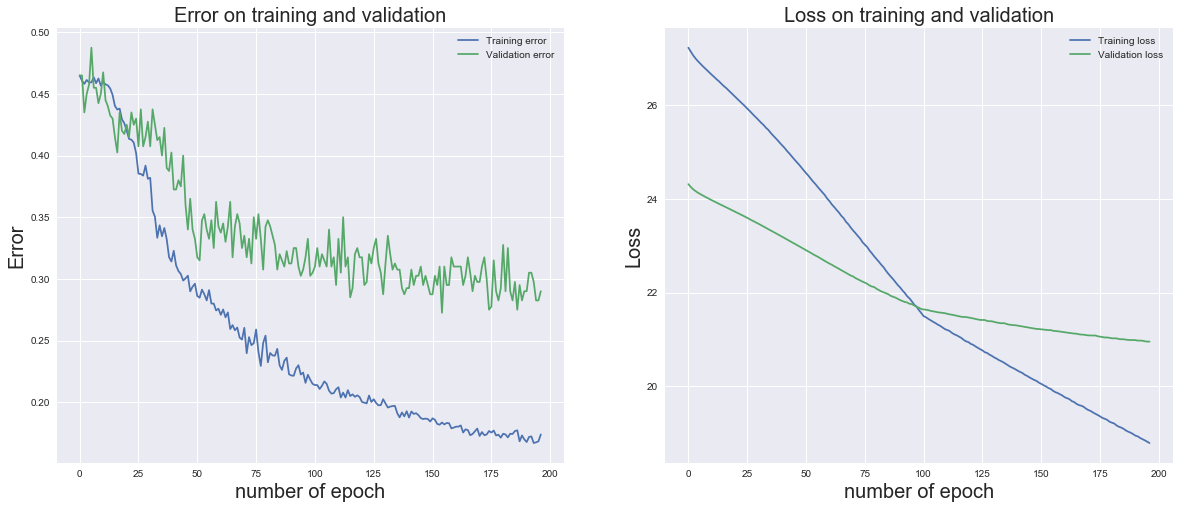

Epoch 197 of 200 took 7.236s
  training error: 	0.173810
  validation error: 	0.290000 
  training loss: 	18.782474
  validation loss: 	20.950792 
batch num:  1
batch num:  2
batch num:  3
batch num:  4
batch num:  5
batch num:  6
batch num:  7
batch num:  8
batch num:  9
batch num:  10
batch num:  11
batch num:  12
batch num:  13
batch num:  14
batch num:  15
batch num:  16
batch num:  17
batch num:  18


KeyboardInterrupt: 

In [31]:
from sklearn.model_selection import RepeatedStratifiedKFold
random_state = 42
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
i = 0
loss = []
acc = []
i = 1
for tr, tst in cv.split(X, y_enc):
#     print(X[train], X[test], y_enc[train], y_enc[test])
    print('Training {}'.format(i))
    train_loss, val_loss, train_error, val_error = train(X[tr], y_enc[tr], X[tst], y_enc[tst])
    loss.append(val_loss[-1])
    acc.append(1 - val_error[-1])
    i += 1

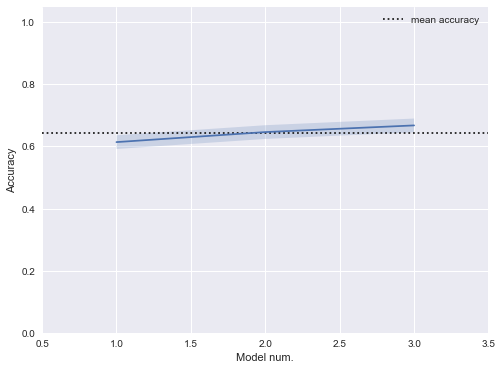

In [32]:
import seaborn as sns; sns.set(color_codes=True)
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(range(1,len(acc)+1), acc)
ax.hlines(np.array(acc).mean(), 0.5,len(acc)+0.5, linestyles ='dotted', label='mean accuracy')
ax.fill_between(range(1,len(acc)+1), np.array(acc)-np.array(acc).std(), np.array(acc)+np.array(acc).std(), alpha = 0.2)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model num.')
ax.set_ybound(0,1.05)
ax.set_xbound(0.5,len(acc)+0.5)
ax.legend()
# fig.savefig('Rnet_dep.png')

In [39]:
np.array(acc).mean()

0.6425708061002179